In [1]:
# Libraries
import pandas as pd
from src import route_and_map as rm
from src import flights as fl
import datetime

In [6]:
start_airport = "LIS"
must_go = ["SIN", "ADL", "LAX"]
start_date = "2023-01-10"

In [7]:
airports = pd.read_csv("data/airports_cleaned.csv", keep_default_na=False)
airports

,airport_name,city,country,IATA,latitude,longitude,continent_code
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.391998,OC
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001,OC
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005,OC
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977,OC
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001,OC
...,...,...,...,...,...,...,...
5919,Bilogai-Sugapa Airport,Sugapa-Papua Island,Indonesia,UGU,-3.739560,137.031998,AS
5920,Ramon Airport,Eilat,Israel,ETM,29.723694,35.011416,AS
5921,Rustaq Airport,Al Masna'ah,Oman,MNH,23.640556,57.487500,AS
5922,Laguindingan Airport,Cagayan de Oro City,Philippines,CGY,8.612203,124.456496,AS


In [8]:
routes = pd.read_csv("data/routes_cleaned.csv", keep_default_na=False)
routes

,source,destination,source_lat,source_lon,source_code,dest_lat,dest_lon,dest_code,distance
0,AER,KZN,43.449902,39.956600,EU,55.606201,49.278702,EU,1507.99
1,ASF,KZN,46.283298,48.006302,EU,55.606201,49.278702,EU,1040.94
2,CEK,KZN,55.305801,61.503300,EU,55.606201,49.278702,EU,773.13
3,DME,KZN,55.408798,37.906300,EU,55.606201,49.278702,EU,718.08
4,EGO,KZN,50.643799,36.590099,EU,55.606201,49.278702,EU,1010.82
...,...,...,...,...,...,...,...,...,...
36601,ZKE,YFA,52.282501,-81.677803,NA,52.201401,-81.696899,NA,9.12
36602,YPO,YAT,54.988098,-85.443298,NA,52.927502,-82.431900,NA,302.73
36603,ZKE,YAT,52.282501,-81.677803,NA,52.927502,-82.431900,NA,88.10
36604,JCK,RCM,-20.668301,141.723007,OC,-20.701900,143.115005,OC,145.08


In [9]:
G = rm.get_G(airports, routes)
sites = rm.find_route(G, start_airport, must_go)
sites

['LIS',
 'TNG',
 'CMN',
 'RAI',
 'FOR',
 'BEL',
 'PBM',
 'POS',
 'IAH',
 'LAX',
 'BNE',
 'ADL',
 'SIN',
 'FCO',
 'LIS']

In [10]:
sites_pairs = rm.get_sites_pairs(sites)
sites_pairs

[('LIS', 'TNG'),
 ('TNG', 'CMN'),
 ('CMN', 'RAI'),
 ('RAI', 'FOR'),
 ('FOR', 'BEL'),
 ('BEL', 'PBM'),
 ('PBM', 'POS'),
 ('POS', 'IAH'),
 ('IAH', 'LAX'),
 ('LAX', 'BNE'),
 ('BNE', 'ADL'),
 ('ADL', 'SIN'),
 ('SIN', 'FCO'),
 ('FCO', 'LIS')]

In [11]:
rm.get_total_distance(G, sites_pairs)

45861.36

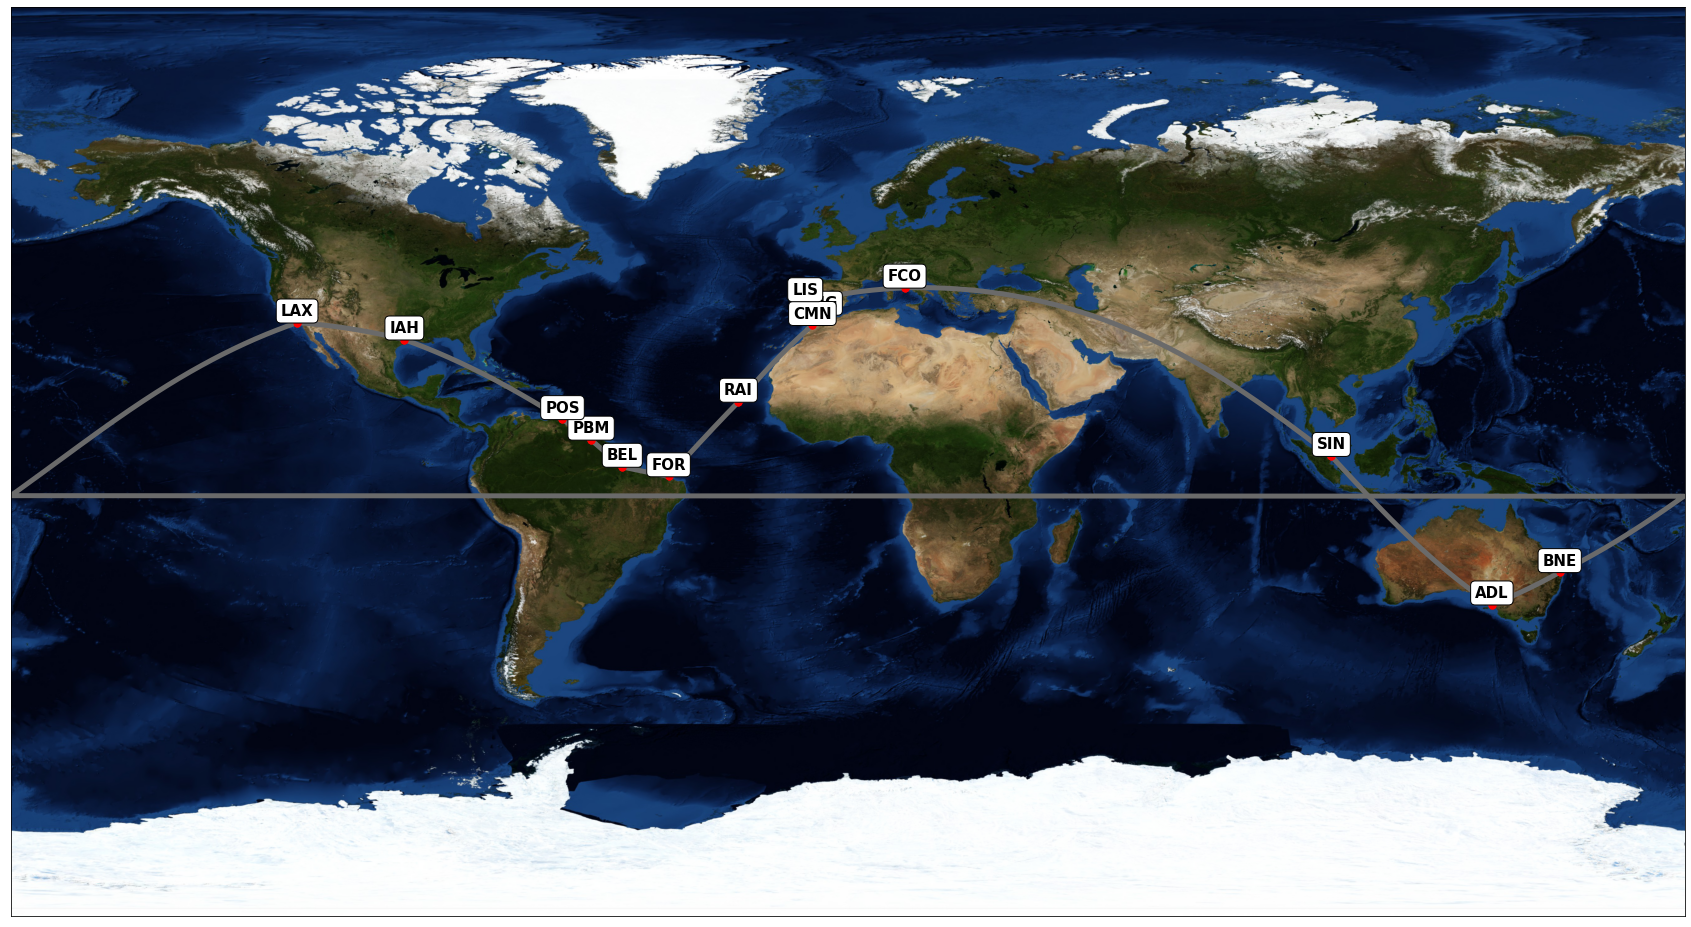

In [12]:
rm.get_map(G, sites, sites_pairs)

In [13]:
for i in range(len(sites_pairs)):
    flight = fl.get_flight(sites_pairs[i][0],sites_pairs[i][1],start_date)
    flight_details = fl.get_flight_details(flight)

    next_date = (datetime.datetime.strptime(start_date,"%Y-%m-%d") + datetime.timedelta(days=7)).date()
    start_date = str(next_date)
    
    print(flight_details)

['11/1', '6:30', '12:55', 'Iberia', '50€']
['17/1', '7:15', '8:35', 'Royal Air Maroc', '84€']
['25/1', '22:30', '0:35', 'Royal Air Maroc', '393€']
['2/2', '1:05', '21:45', 'TAP AIR PORTUGAL', '723€']
['8/2', '9:15', '11:10', 'Azul', '51€']
['14/2', '0:10', '2:05', 'GOL', '137€']
['22/2', '5:00', '5:30', 'Caribbean Airlines', '140€']
['2/3', '16:07', '0:29', 'American Airlines', '366€']
['7/3', '12:01', '13:48', 'Spirit Airlines', '74€']
['12/3', '20:55', '9:50', 'Air New Zealand', '730€']
['22/3', '18:20', '21:25', 'Jetstar', '87€']
['28/3', '10:45', '20:25', 'Malaysia Airlines', '395€']
['4/4', '9:10', '18:45', 'Turkish Airlines', '398€']
['11/4', '17:35', '19:45', 'TAP AIR PORTUGAL', '92€']
